# 決定木とは何か
決定きとは段階的にデータを分割していき、木のような分析結果を出力するもの。
ざっくり言うとある特徴量のある値を境に目的変数を分岐させるようにする手法。

決定木の特徴としては、解釈が容易で、妥当性を判断しやすいのが決定木分析の強み。
データが分割されていく流れをなんとなく把握することが目的なことが多い。
数値データやカテゴリーデータが混在しても、利用可能でかつデータを分割する指標として
特徴量を使うので、データのスケーリングなどが必要ない。
ただ、決定木分析は訓練データに対して過剰適合してしまいがち。
そのため汎化性能の向上を目的とする対策が必要となる。

# ロジスティック回帰などとの比較
判別や回帰問題の手法に着目する時に、モデル選択の評価として重要なのは、「予測精度」と、「中身のわかりやすさ」の２点。
分析の目的に応じて、手法を選択する
線形回帰：説明変数の予測値への寄与を大雑把に知りたい場合
SVM :予測の正解さを求めたい時
CART(ランダムフォレスト):予測精度が実用的で、因果関係の類推も行いたい場合。


# ジニ不純度とは何か
$ I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})$ 
P*Pの部分について。
この部分は同じことが起る事象　= 隔たり具合　と考えることで、この値が小さいほど少ないことを表していて、大きいほど隔たりがある。逆に、１からこの値を引くと、「P_1とP_2の組み合わせになる確率と定義できるから、不純（ミスマッチ）のを示す尺度になる。
つまり、ジニ係数が低いほど、不純度が低くなる。

# 決定木は情報利得をどのように使うことで学習するか
決定木では、トレーニングサンプルのグループであるノードを質問を繰り返して、いくことで分割していく。
そこで、分割前のノードを親ノード、分割後のノードを子ノードとする。
親ノードと子ノードの不純度計算して、その差分の情報利得が最大になるように子ノードを分けていく。


# データセットの用意

In [14]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# データセットの描画

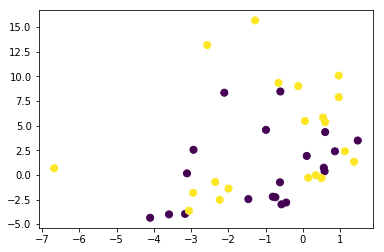

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0], X[:,1], s=50, c=y, marker='o')

# クラスを定義

In [16]:
class Scratch_DecisionTree:
    
    #メンバ変数を定義
    def __init__(self,depth=1,gini=0,gini_min=999):
        #深さ
        self.depth =depth   
        #ジニ不純度の最小値
        self.gini_min = gini_min
        self.best_f = None
        #ジニ不純度
        self.best_thrs = None
        self.sample_num = len(X)
    def gini_score(self,X,y,f_id, threshold):
#         sample_num = X.shape[0]
        gini = 0
        y_split = [y[X[:,f_id] >= threshold],y[X[:,f_id] < threshold]]
       #閾値を超えたグループとそうでないグループで場合分け
        for group in y_split:
            score = 0
            #グループでユニークな値（正解ラベルを取得）
            classes = np.unique(group)
            #Cartで全てのその特徴量で、全ての値を閾値にしてジニ不純度を計算
            #正解ラベルごとの確率をだすので
            #ユニークな正解ラベルをそれぞれのループで回す
            for cls in classes:
                #確率を計算
                p = np.sum(group == cls)/len(group)
                #ジニ不純度計算式の一部
                score += p * p
            #ジニ不純度計算式
            gini += (1- score) * (len(group)/self.sample_num)
        
        return gini
    def search_best_split(self,X, y): 
        #特徴量の数
        features = X.shape[1]
        gini = None
        #特徴量ごとにループ
        for f_id in range(features):
            #各特徴量の値を取得
            values = X[:, f_id]
            #各値を閾値にする
            for threshold in values:
             #ノードに流れてくるデータと、それに紐づいたクラスラベル(y)
            #を渡すことで、変数giniが最小となる時の閾値と説明変数を取得
                gini = self.gini_score(X,y,f_id,threshold)
             #特徴と閾値を決定する
            #これまでの最小値の方が大きければ、gini_minを更新
                if self.gini_min > gini:
                    
                    self.gini_min = gini
#                     print(self.gini_min)
                    self.best_thrs =  threshold
                    self.best_f = f_id
            
    #ノードを分割する関数
    def split(self,X,y):
        count = 0 
        while (count < self.depth):
            gini_min, best_thrs, best_f = self.search_best_split(X,y)
            #ある特徴量の閾値を超えたかそうでないかで分割して、ブーリアンインデックスで取得
            id_left = X[:, self.best_f] >= self.best_thrs
            id_right = X[:, self.best_f] < self.best_thrs

            #分割するデータを定義
            self.left = X[id_left]
            self.right =  X[id_right]
            
            #分割回数を記録
            count +=1
#             print(count)

    def predict(self,X):
        pred = np.zeros(len(X))
        #敷値を超えたindexを取得
        index_label0 = np.where(X[:,self.best_f] >= self.best_thrs)
        index_label1 = np.where(X[:,self.best_f] < self.best_thrs)

        pred[index_label0] = 0
        pred[index_label1] = 1

        return pred.astype(int)
    
        def predict(self, data):
            if data[:,self.feature] > self.threshold:
                return self.left.predict(data)
            else:
                return self.right.predict(data)

        

# インスタンスを生成

In [17]:
model =Scratch_DecisionTree()

# 学習

In [18]:
model.search_best_split(X,y)

#  予測

In [19]:
model.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [20]:
pred = model.predict(X)

# 評価

In [21]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [22]:
accuracy_score(y,pred)

0.325

In [23]:
recall_score(y,pred)

0.55

In [24]:
f1_score(y,pred)

0.4489795918367347

In [25]:
precision_score(y,pred)

0.3793103448275862

# 閾値をプロット

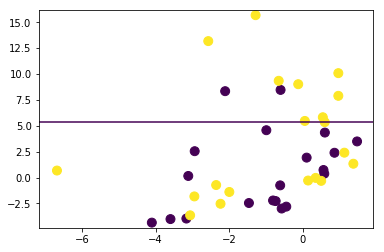

In [27]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], s=80, c=y, marker='o')

step = 0.1
mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
pred = model.predict(mesh).reshape(mesh_f0.shape)
plt.contour(mesh_f0, mesh_f1, pred, 1)
plt.show()